# Test of Doppler lags for the observed oscillations

Following tests are scripted for comprehensive characterization
- convergence to reference orbit with zero lags
- impact of a uniform lag in the Doppler (range rate) data
- impact of light-time lags, i.e., radial acceleration and light time
- impact of light-time lags times a scale factor


In [1]:
from astropy import units as u
sampling_interval = 1*u.hour
tracking_period = 5*u.day

In [2]:
from astropy import constants as const
from astropy import visualization
from astropy.coordinates import solar_system_ephemeris

from poliastro.util import norm
from poliastro.twobody.sampling import EpochsArray

import numpy as np
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sim.stations import dss25, dss34
from sim.tracking import Tracking
from sim.util import orbit_from_horizons, make_epochs
from sim.util import describe_orbit, describe_trajectory, plot_residual, plot_swings
from sim.fitorbit import OrbitFitter

def plots(epochs, residual, title, ylab, ylabs=None):
    plot_residual(epochs, residual, title, 'Residual ' + ylab)
    try:
        plot_swings(epochs, residual, None, 'Residual swings ' + ylab)
    except ValueError:
        # no swings identified
        pass

def fitv(ref_orbit, ref_stations, epochs, sim_meas, title, _trace=False):
    fitter = OrbitFitter(ref_orbit, ref_stations, trace=_trace)
    fitter.fit_doppler_data(epochs, sim_meas)
    print(fitter.report())
    print('Time elapsed (hh:mm:ss.ms) {}'.format(fitter.runtime))
    describe_orbit(fitter.orbit)
    plots(epochs, fitter.result.residual, title, 'doppler (mm/s)')
    return fitter

def reusefitv(fitsolution, epochs, sim_meas, title):
    residual = fitsolution.doppler_residual(epochs, sim_meas)
    plots(epochs, residual, title, 'doppler (mm/s)')
    return residual

In [3]:
solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value

near_goldstone_orbit = orbit_from_horizons("NEAR", goldstone_end)
describe_orbit(near_goldstone_orbit)


::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437.250829758486 km
Semimajor axix: -8494.322039490264 km
Periapse radius: 6908.917068596319 km , altitude: 530.7804685963192 km


In [4]:
canberra_start = Tracking.NEAR_CANBERRA_START.value
canberra_end = canberra_start + tracking_period
epochs = make_epochs(canberra_start, canberra_end, sampling_interval)
print("Start and end:", epochs[0], epochs[-1], "[", epochs.size, "]")

near_extended_ephem = near_goldstone_orbit.to_ephem(EpochsArray(epochs))
describe_trajectory(near_extended_ephem, dss34)

Start and end: 1998-01-23 09:53:55.600 1998-01-28 08:53:55.600 [ 120 ]

::TRAJECTORY::
Start and end ranges: 99245.53506879517 km 3036238.749304457 km
Start and end radial speeds: 7.3215953575806205 km / s 6.784339915683987 km / s
Closest: 73145.67731807531 km speed 7.5891622264313146 km / s  at  1998-01-23 09:53:55.600
Deflection: 0.4576006592003391 deg


In [5]:
vdata_ref = []
vlags = []
vlags_full = []
vdata_constvlags = []
vdata_ltlags_full = []
vdata_ltlags = []
vdata_scaledlags = []

scalefactor = 0.1
first_vlag = None

for e in epochs[:-1]:
    ref_r, ref_rr, ref_ra, ref_rs = dss34.range_rate_accel(near_extended_ephem, e)
    print(e.strftime("%H:%M:%S"),
         ref_r.to_value(u.km),
         ref_ra.to_value(u.m/(u.s*u.s)),
         ref_rs.to_value(u.m/(u.s*u.s)),
         (ref_ra+ref_rs).to_value(u.m/(u.s*u.s)),
         )

    vlag_full = ref_ra*ref_r/const.c
    vlag = (ref_ra+ref_rs)*ref_r/const.c

    if first_vlag is None:
        first_vlag = vlag

    vlags.append(vlag)
    vlags_full.append(vlag_full)

    vdata_ref.append([ref_rr])
    vdata_constvlags.append([ref_rr - first_vlag])
    vdata_ltlags_full.append([ref_rr - vlag_full])
    vdata_ltlags.append([ref_rr - vlag])
    vdata_scaledlags.append([ref_rr - scalefactor*vlag])

09:53:55 73145.67731807531 -0.04185446138826876 0.011929755963438482 -0.029924705424830278
10:53:55 99245.53506879517 -0.030595436621538852 0.006932690358465998 -0.023662746263072854
11:53:55 124952.87161867223 -0.019041945850339914 0.0032175635627240684 -0.015824382287615846
12:53:55 150406.9184295078 -0.011860369000693538 2.6506270511816865e-06 -0.011857718373642356
13:53:55 175705.91811305322 -0.006180571290315129 -0.0028398372182852905 -0.00902040850860042
14:53:55 200923.1566432872 -0.001905957354608745 -0.005264460139278726 -0.007170417493887471
15:53:55 226114.57896320475 0.0013301524148801036 -0.0071815428762112 -0.005851390461331096
16:53:55 251322.18234644702 0.0036056157108887987 -0.008505454294420456 -0.004899838583531657
17:53:55 276575.54513441963 0.004989725515436305 -0.009177218078984528 -0.004187492563548223
18:53:55 301892.6622299074 0.005534830002318358 -0.009175534371692884 -0.0036407043693745256
19:53:55 327280.67774089554 0.005311923270134855 -0.008521064074167028

08:53:55 2442573.7539199213 -0.006152896218303283 0.0060838178278094235 -6.907839049385966e-05
09:53:55 2466983.5805476434 -0.0043659610158286455 0.004299600464219289 -6.636055160935683e-05
10:53:55 2491337.1410296927 -0.0022835732584880475 0.0022199632512681644 -6.361000721988308e-05
11:53:55 2515661.268365254 -4.8157314580521415e-05 -1.277728417514723e-05 -6.0934598755668645e-05
12:53:55 2539984.7674061717 0.0021871093105474415 -0.002245547248480584 -5.8437937933142337e-05
13:53:55 2564336.441055907 0.004268784558725258 -0.004324994307469687 -5.620974874442908e-05
14:53:55 2588743.113118824 0.006053745686074308 -0.006108063414167475 -5.431772809316726e-05
15:53:55 2613227.784174853 0.007419125334529042 -0.007471927420482638 -5.2802085953596034e-05
16:53:55 2637808.0484656626 0.008270885031080866 -0.008322558463492308 -5.1673432411442066e-05
17:53:55 2662494.882235384 0.008550397779139018 -0.008601311887524278 -5.091410838525996e-05
18:53:55 2687291.888305128 0.008238552053008164 -0.0

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8
    # data points      = 119
    # variables        = 6
    chi-square         = 2.3350e-22
    reduced chi-square = 2.0664e-24
    Akaike info crit   = -6483.96861
    Bayesian info crit = -6467.29387
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
    nu:    at initial value
    raan:  at initial value
    argp:  at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.83942476 (init = -1.839425)
    raan:  1.54005925 (init = 1.540059)
    argp:  2.53325839 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:00:04.731688

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 690

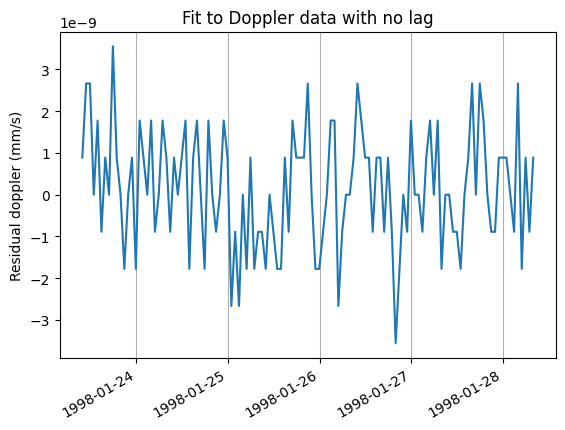

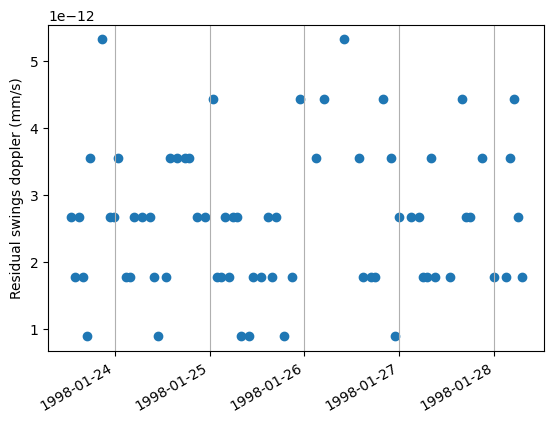

In [6]:
fitv(near_goldstone_orbit, [dss34], epochs[:-1], vdata_ref, "Fit to Doppler data with no lag")

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 119
    # variables        = 6
    chi-square         = 0.00543538
    reduced chi-square = 4.8101e-05
    Akaike info crit   = -1177.27998
    Bayesian info crit = -1160.60524
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.83948553 (init = -1.839425)
    raan:  1.53989519 (init = 1.540059)
    argp:  2.53320698 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:00:07.876587

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 6908917.068596319 m , altitude: 530780.4685963197 m
[0.003626505538534275, 0.003445595

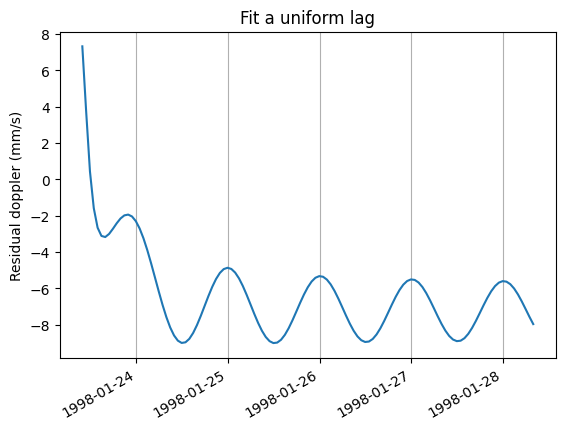

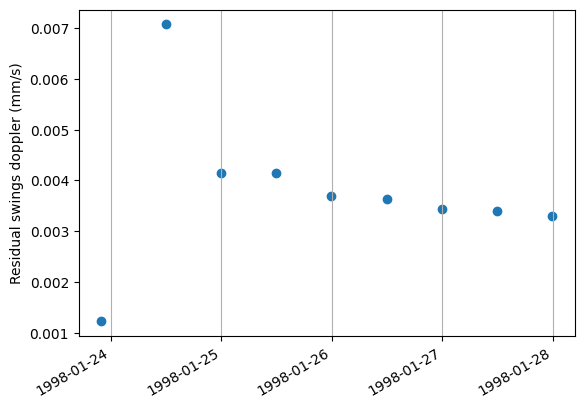

In [7]:
constfitv = fitv(near_goldstone_orbit, [dss34], epochs[:-1], vdata_constvlags, "Fit a uniform lag")

[0.003626505538534275, 0.00344559571718861, 0.003399935932790754, 0.0033053801784532766]


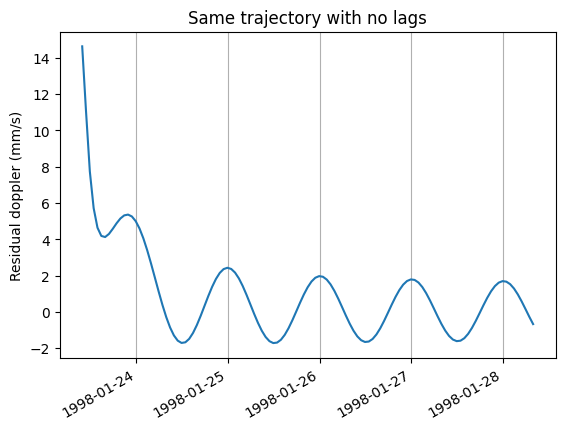

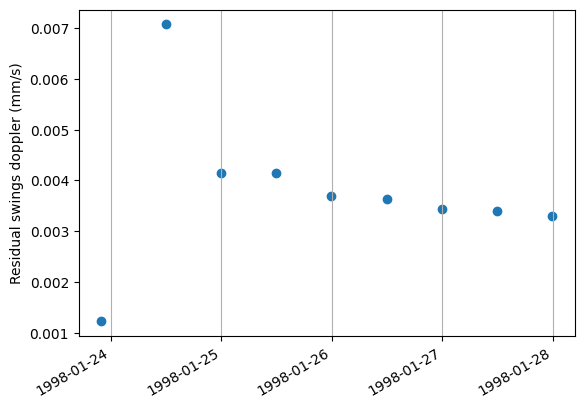

In [8]:
_ = reusefitv(constfitv, epochs[:-1], vdata_ref, "Same trajectory with no lags")

[0.0034715843337806973, 0.0035085532310574763, 0.003307613614111915, 0.003339221036569029]


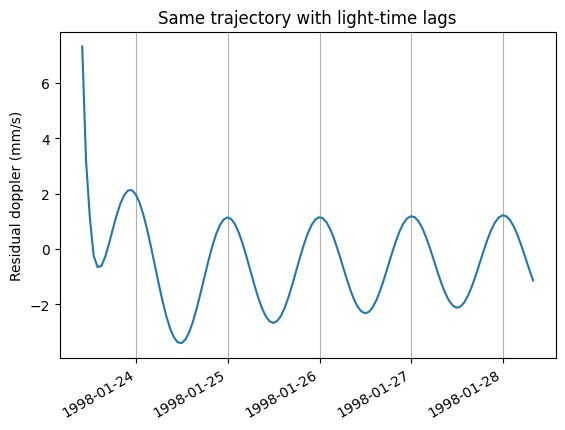

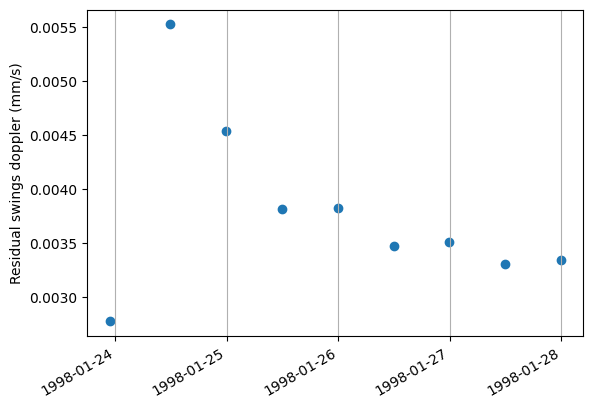

In [9]:
_ = reusefitv(constfitv, epochs[:-1], vdata_ltlags, "Same trajectory with light-time lags")

[0.1102398063084209, 0.1270950384348879, 0.144177126546019, 0.16105035361047015]


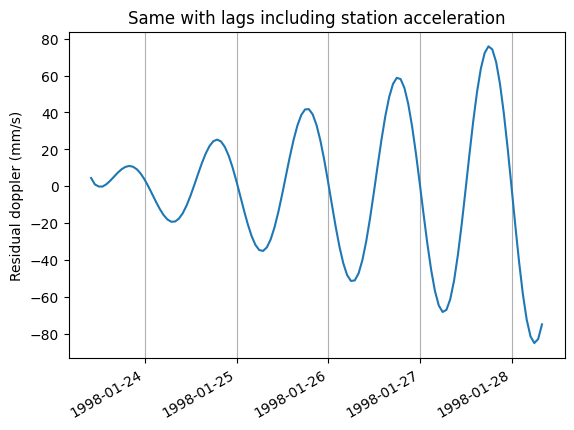

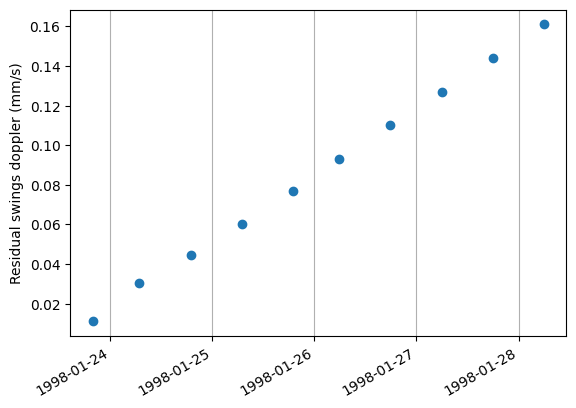

In [10]:
_ = reusefitv(constfitv, epochs[:-1], vdata_ltlags_full, "Same with lags including station acceleration")

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 119
    # variables        = 6
    chi-square         = 1.4755e-04
    reduced chi-square = 1.3058e-06
    Akaike info crit   = -1606.45364
    Bayesian info crit = -1589.77890
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
    argp:  at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.83945737 (init = -1.839425)
    raan:  1.54000416 (init = 1.540059)
    argp:  2.53324142 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:00:07.744129

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 6908917.068596319 m , altitude: 530780.4685963197 m
[0.001

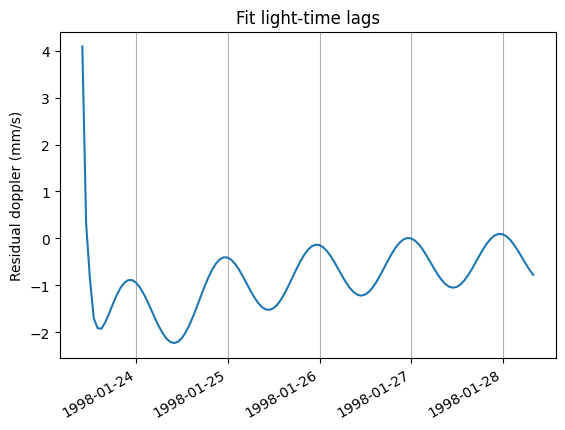

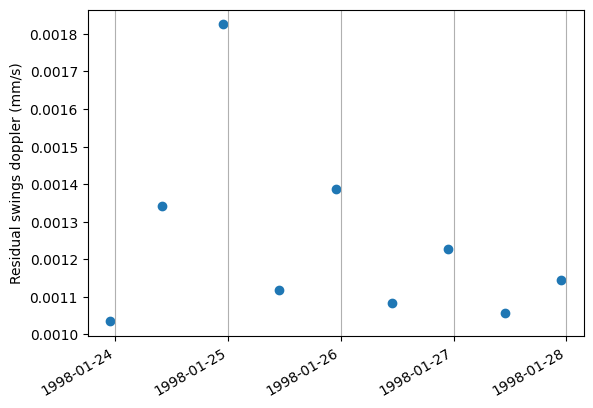

In [11]:
ltfitv = fitv(near_goldstone_orbit, [dss34], epochs[:-1], vdata_ltlags, "Fit light-time lags")

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 119
    # variables        = 6
    chi-square         = 1.4755e-06
    reduced chi-square = 1.3057e-08
    Akaike info crit   = -2154.47375
    Bayesian info crit = -2137.79901
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
    nu:    at initial value
    raan:  at initial value
    argp:  at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.83942802 (init = -1.839425)
    raan:  1.54005374 (init = 1.540059)
    argp:  2.53325669 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:00:08.002537

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 69

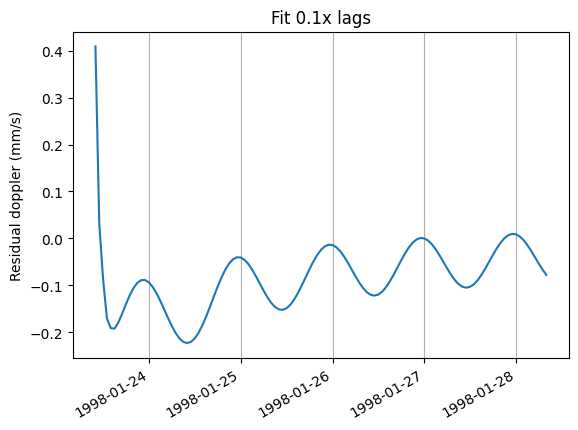

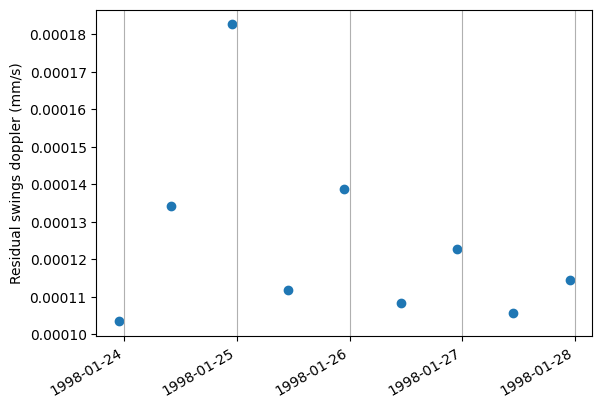

In [12]:
scaledfitv = fitv(near_goldstone_orbit, [dss34], epochs[:-1], vdata_scaledlags, f'Fit {scalefactor}x lags')

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 119
    # variables        = 6
    chi-square         = 0.03756345
    reduced chi-square = 3.3242e-04
    Akaike info crit   = -947.240815
    Bayesian info crit = -930.566074
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.83948697 (init = -1.839425)
    raan:  1.53991653 (init = 1.540059)
    argp:  2.53309435 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:00:10.825255

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 6908917.068596319 m , altitude: 530780.4685963197 m
[0.02594836570057879, 0.0402267647

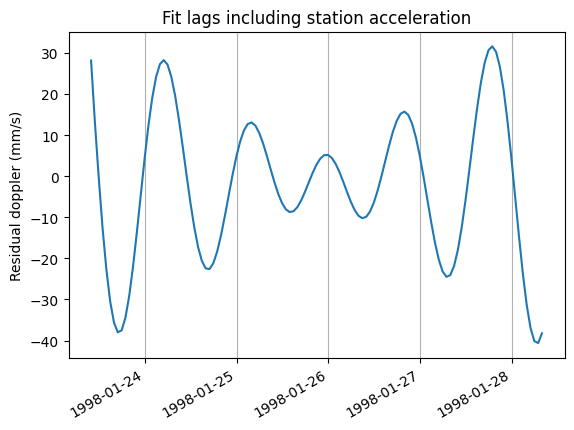

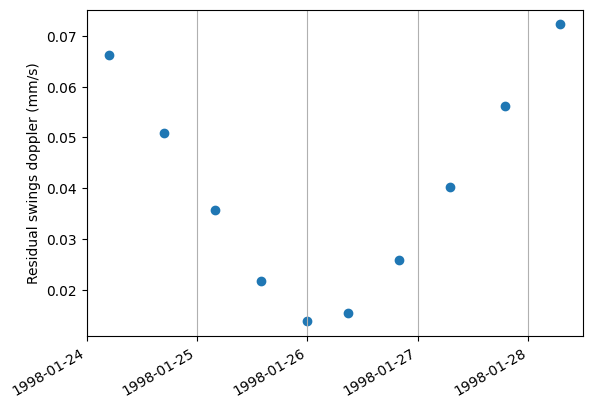

In [13]:
fltfitv = fitv(near_goldstone_orbit, [dss34], epochs[:-1], vdata_ltlags_full, "Fit lags including station acceleration")

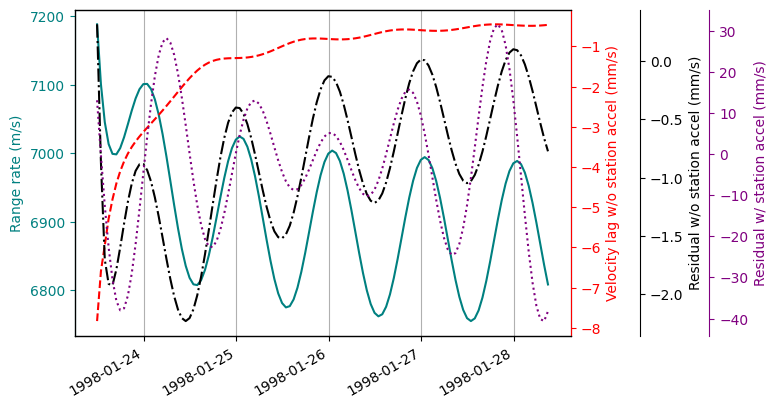

In [14]:
with visualization.time_support():
    fig, ax = plt.subplots()
    plt.xlabel('')
    plt.grid(axis='x')

    if tracking_period > 5*u.day:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    else:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

    ax.set_ylabel('Range rate (m/s)', color = "teal")
    ax.spines['left'].set(color="teal")
    ax.tick_params(axis="y", colors="teal")

    ax2 = ax.twinx()
    ax2.set_ylabel('Velocity lag w/o station accel (mm/s)', color = "red")
    ax2.spines['right'].set(color="red")
    ax2.tick_params(axis="y", colors="red")

    ax3 = ax.twinx()
    ax3.set_ylabel('Residual w/o station accel (mm/s)', color = "black")
    ax3.spines['right'].set_position(('outward', 50))

    ax4 = ax.twinx()
    ax4.set_ylabel('Residual w/ station accel (mm/s)', color = "purple")
    ax4.spines['right'].set(position=('outward', 100), color = "purple")
    ax4.tick_params(axis="y", colors="purple")

    #h1 = ax4.axhline(y = 929, linestyle = "dashed", color='black', label="Earth SOI")
    #h2 = ax4.axhline(y = 384.4, linestyle = "dotted", color='black', label="Distance to moon")

    p1, = ax.plot(epochs[2:], [v[0].to_value(u.m/u.s) for v in vdata_ref[1:]],
                  color="teal", label="Range rate")
    p2, = ax2.plot(epochs[2:], [v.to_value(u.mm/u.s) for v in vlags[1:]],
                   linestyle = "dashed", color="red", label="lag w/o station accel")

    p3, = ax3.plot(epochs[2:], [1e3*v for v in ltfitv.result.residual[1:]],
                   linestyle='-.', color="black", label="residual w/o station accel")
    p4, = ax4.plot(epochs[2:], [1e3*v for v in fltfitv.result.residual[1:]],
                   linestyle=":", color="purple", label="residual")

    #ax.legend(handles=[p1, p4, p2, p3], loc="lower right", ncol=2)
    plt.gcf().autofmt_xdate()

    plt.savefig(f'near_sim_postencounter_doppler-{int(tracking_period.to_value(u.day))}d.pdf', bbox_inches='tight')